# Add Folders to Path

In [1]:
%%time
import sys, os
# get current directory
path = os.getcwd()
# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])
# add Algorithm folder to current working path in order to access the functions inside the folder ´Algorithms´
sys.path.append(parent_directory+"/Algorithm")

CPU times: user 427 µs, sys: 302 µs, total: 729 µs
Wall time: 539 µs


# Agulhas Region

## AVISO Data from Agulhas Region

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../Data/Agulhas_AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time = mat_file['t']

CPU times: user 357 ms, sys: 117 ms, total: 475 ms
Wall time: 474 ms


## Data/Parameters for Dynamical System

In [3]:
import numpy as np

# Number of cores to be used for parallel computing
Ncores = 30

# Incompressible/Compressible flow. {True, False}
Incompressible = True

# Periodic boundary conditions
periodic_x = False
periodic_y = False
Periodic = [periodic_x, periodic_y]

## Compute Meshgrid
X, Y = np.meshgrid(x, y)

# List of parameters of the flow.
params_data = {"X": X, "Y": Y, "Time": time, "U": U, "V": V, "Ncores": Ncores, 
               "Incompressible": Incompressible, "Periodic": Periodic}

<a id='Spatio-Temporal-Domain-of-Dynamical-System'></a>
## Spatio-Temporal Domain of Dynamical System

In [4]:
%%time
# Initial time (in days)
t0 = 25

# Final time (in days)
tN = 45

# time step-size
dt = .1

time = np.arange(t0, tN+dt, dt)

# longitudinal and latitudinal boundaries (in degrees)
xmin = 0
xmax = 5
ymin = -35
ymax = -30

# spacing of meshgrid (in degrees)
dx = 0.025
dy = 0.025

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

params_DS = {"time": time, "X_domain": X_domain, "Y_domain": Y_domain}

CPU times: user 1.25 ms, sys: 1.13 ms, total: 2.37 ms
Wall time: 1.24 ms


In [5]:
# Initialize Dynamical System
from ipynb.fs.defs.Dynamical_System import *

DS = Dynamical_System(params_data, params_DS)

## Velocity Interpolation

In [6]:
%%time
# Interpolate velocity data using cubic spatial interpolation
DS._Interpolation_velocity("cubic")

CPU times: user 443 ms, sys: 56.2 ms, total: 499 ms
Wall time: 498 ms


## Trajectory/Velocity  Computation

Trajectories are launched from the grid of initial conditions specified in [Section 2.3](#Spatio-Temporal-Domain-of-Dynamical-System) **(Line 14-17)**.

The temporal domain as well as the time resolution is also specified in [Section 2.3](#Spatio-Temporal-Domain-of-Dynamical-System) **(Line 2-11)**.

In [7]:
trajectory_grid, velocity_grid = DS._trajectory_grid();

  0%|          | 0/201 [00:00<?, ?it/s]

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:  4.3min
[Parallel(n_jobs=30)]: Done 201 out of 201 | elapsed:  5.9min finished


## Spatio-Temporal Average of Velocity

In [8]:
u_mean = np.nanmean(velocity_grid[:,:,0,:])
v_mean = np.nanmean(velocity_grid[:,:,1,:])

v0 = np.sqrt(u_mean**2+v_mean**2)

## Trajectory Stretching Exponent (TSE)

In [9]:
from ipynb.fs.defs.TSE import _TSE
TSE = _TSE(tN-t0, velocity_grid, v0)

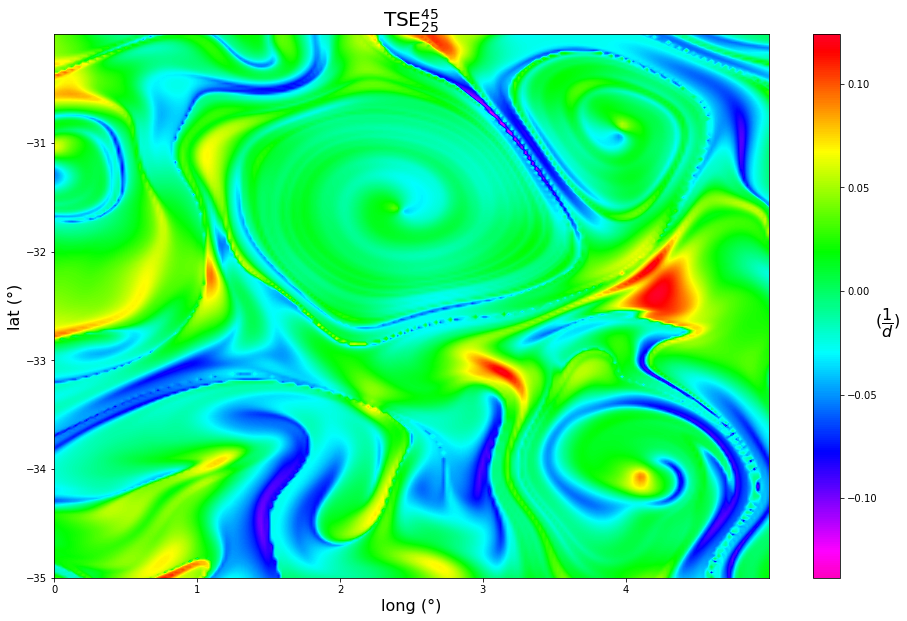

In [53]:
######################## PLOT RESULTS ########################
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(16, 10))
ax = plt.axes()

# Contourplot of TSE over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, TSE, cmap = "gist_rainbow_r", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 16)
ax.set_ylabel("lat (°)", fontsize = 16)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), 1))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(-.15, .15, 7))
cbar.ax.set_ylabel(r'$(\dfrac{1}{d})$', rotation = 0, labelpad = 10, fontsize = 16)

ax.set_title(r'$\mathrm{TSE}$' + f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$', fontsize = 20)

plt.show()

## Trajectory Stretching Exponent without Cancellations ($ \mathrm{\overline{TSE}}$)

In [11]:
from ipynb.fs.defs.TSE_bar import _TSE_bar
TSE_bar = _TSE_bar(tN-t0, velocity_grid, v0)

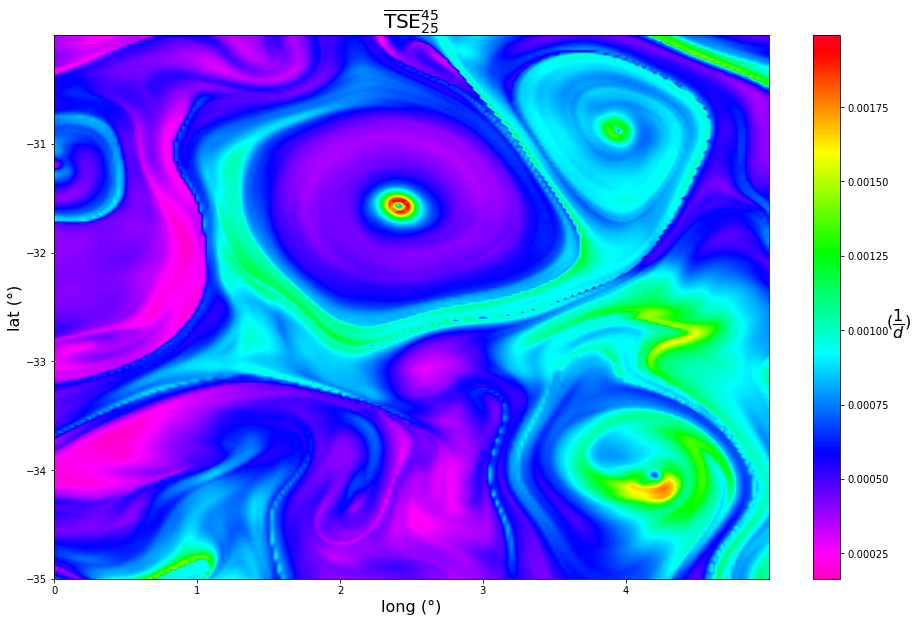

In [52]:
######################## PLOT RESULTS ########################

# Figure/Axis
fig = plt.figure(figsize=(16, 10))
ax = plt.axes()

# Contourplot of TSE over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, TSE_bar, cmap = "gist_rainbow_r", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 16)
ax.set_ylabel("lat (°)", fontsize = 16)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), 1))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(0, 0.002, 9))
cbar.ax.set_ylabel(r'$(\dfrac{1}{d})$', rotation = 0, labelpad = 10, fontsize = 16)

ax.set_title(r'$\mathrm{\overline{TSE}}$' + f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$', fontsize = 20)

plt.show()